<a href="https://colab.research.google.com/github/OndwelaT/OndwelaT.github.io/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naïve Bayes

In [ ]:

!pip install pyspellchecker
import pandas as pd
from spellchecker import SpellChecker

# Load the Excel file
df = pd.read_excel('/content/Clean Text.xlsx')

# Create a SpellChecker object
spell = SpellChecker()

# Function to correct spelling and lowercase text
def correct_spelling_and_lowercase(text):
    if isinstance(text, str):
        words = text.split()
        corrected_words = [spell.correction(word).lower() for word in words]
        return ' '.join(corrected_words)
    return text

# Apply the function to the 'Sentiment' column
df['Sentiment'] = df['Sentiment'].apply(correct_spelling_and_lowercase)

# Show the first 4 rows of the Sentiment column
print(df['Sentiment'].head(4))

# Save the modified DataFrame to a new Excel file
df.to_excel('Clean Text.xlsx', index=False)



0     neutral
1    positive
2    negative
3    negative
Name: Sentiment, dtype: object


In [ ]:
df.head()

,text,Sentiment
0,the dated s water amp sanitation directorate i...,neutral
1,there is running water in every tap in my hous...,positive
2,urban two beaches are currently closed for swi...,negative
3,urban four beaches are currently closed for s...,negative
4,5. commissioner makoasha and the share mpumala...,positive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# load data

df = pd.read_excel('/content/Clean Text (1).xlsx')
print(df.columns)



Index(['text', 'Sentiment'], dtype='object')


In [ ]:
# split our data set into two groups, a training set and a test set.



X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Sentiment'], test_size=0.2, random_state=42)


In [ ]:
 # remove stop words and # lemmatization

def preprocess_text(text):
    # Handle potential non-string values
    if not isinstance(text, str):
        return ""

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a string
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [ ]:
# Gaussian Naive Bayes algorithm for classification

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Create a TfidfVectorizer to convert text data to numerical features
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Encode the target labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform

In [ ]:
# Train Gaussian Naive bayes model

# Train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train_vec, y_train_encoded)

# Make predictions on the test set
y_pred = gnb.predict(X_test_vec)

# Encode the target labels to numerical values
y_test_encoded = label_encoder.transform(y_test) # Call the transform method

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7948717948717948


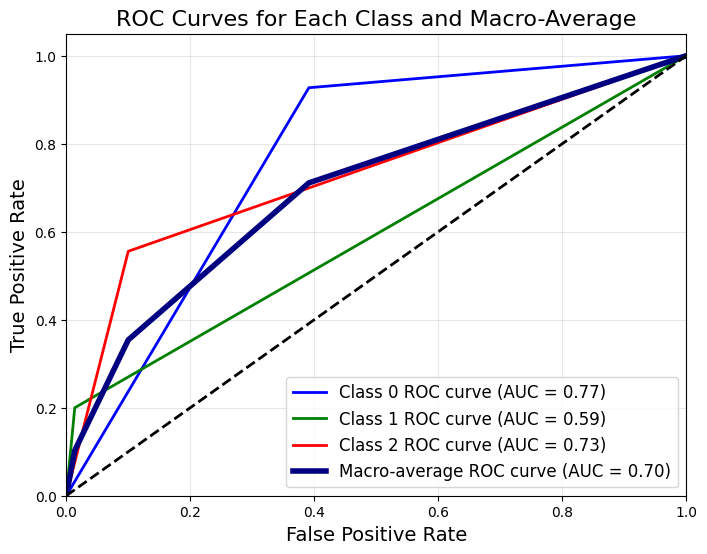

Class 0 ROC AUC: 0.77
Class 1 ROC AUC: 0.59
Class 2 ROC AUC: 0.73
Macro-average ROC AUC: 0.70


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming y_test_encoded and y_pred are defined
# and gnb is your trained classifier with predict_proba method

# Define class labels
class_labels = [0, 1, 2]
n_classes = len(class_labels)

# Binarize the output for ROC computation
y_test_binarized = label_binarize(y_test_encoded, classes=class_labels)

# Get predicted probabilities
y_score = gnb.predict_proba(X_test_vec)

# Ensure that y_score has the same order of classes as class_labels
# gnb.classes_ contains the order of classes in predict_proba
# If not, reorder y_score accordingly
if not np.array_equal(gnb.classes_, class_labels):
    # Reorder y_score columns to match class_labels
    sorted_indices = [list(gnb.classes_).index(cls) for cls in class_labels]
    y_score = y_score[:, sorted_indices]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(class_labels):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[cls] for cls in class_labels]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for cls in class_labels:
    mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC Curve for each class and the macro-average ROC curve
plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red']

# Plot each class's ROC curve
for i, cls in enumerate(class_labels):
    plt.plot(fpr[cls], tpr[cls], color=colors[i], lw=2,
             label=f'Class {cls} ROC curve (AUC = {roc_auc[cls]:0.2f})')

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle='-', linewidth=4)

# Plot the diagonal line for reference (random chance line)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Each Class and Macro-Average', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Print the AUCs for each class and the macro-average
print(f"Class 0 ROC AUC: {roc_auc[0]:.2f}")
print(f"Class 1 ROC AUC: {roc_auc[1]:.2f}")
print(f"Class 2 ROC AUC: {roc_auc[2]:.2f}")
print(f"Macro-average ROC AUC: {roc_auc['macro']:.2f}")


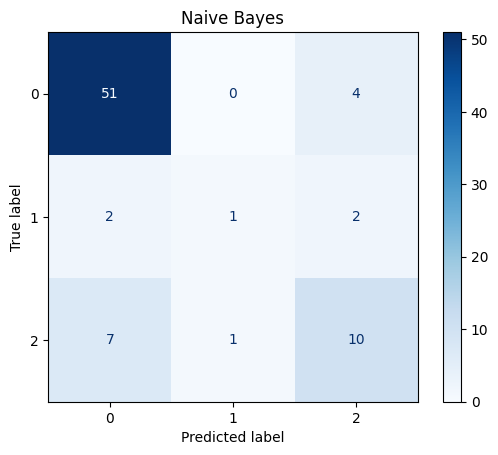

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()
cm = confusion_matrix(y_test_encoded, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1', '2'])
new_var = disp.plot(ax=ax, cmap='Blues', values_format='d') # Pass ax directly
new_var
ax.set_title('Naive Bayes') # Use ax directly for title
plt.show()

# K-NN-Based Classification

KNN Model Evaluation Metrics:
Accuracy: 0.69
Precision (Weighted): 0.65
Recall (Weighted): 0.69
F1 Score (Weighted): 0.67
Confusion Matrix:
[[48  2  5]
 [ 2  1  2]
 [13  0  5]]


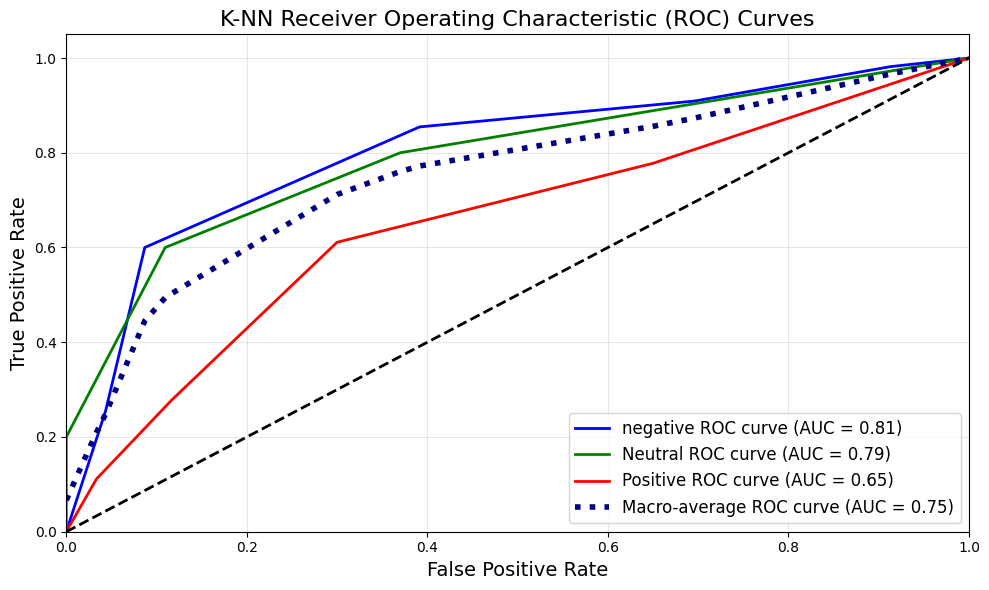

<Figure size 800x600 with 0 Axes>

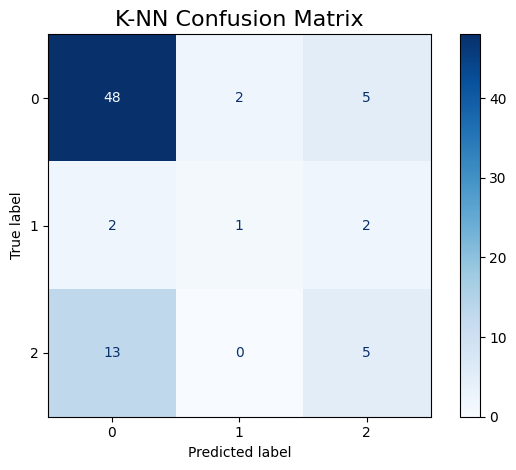

K-NN ROC AUC Scores:
Negative (0) ROC AUC: 0.81
Neutral (1) ROC AUC: 0.79
Positive (2) ROC AUC: 0.65
Macro-average ROC AUC: 0.75


In [ ]:
# Import Necessary Libraries
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import numpy as np

# -----------------------------
# 1. Data Preparation
# -----------------------------

# Assuming you have the following variables already defined:
# X_train_vec: Feature vectors for training
# X_test_vec: Feature vectors for testing
# y_train: True labels for training
# y_test: True labels for testing

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on training labels and transform both training and testing labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define Class Labels
class_labels = [0, 1, 2]  # 0: Negative, 1: Neutral, 2: Positive
n_classes = len(class_labels)

# -----------------------------
# 2. Model Training
# -----------------------------

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the KNN model
knn.fit(X_train_vec, y_train_encoded)

# -----------------------------
# 3. Making Predictions and Evaluations
# -----------------------------

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_vec)

# Evaluate the model
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)
precision_knn = precision_score(y_test_encoded, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test_encoded, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test_encoded, y_pred_knn, average='weighted')
cm_knn = confusion_matrix(y_test_encoded, y_pred_knn, labels=class_labels)

# Print Evaluation Metrics
print("KNN Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_knn:.2f}")
print(f"Precision (Weighted): {precision_knn:.2f}")
print(f"Recall (Weighted): {recall_knn:.2f}")
print(f"F1 Score (Weighted): {f1_knn:.2f}")
print("Confusion Matrix:")
print(cm_knn)

# -----------------------------
# 4. ROC Curve Analysis
# -----------------------------

# Binarize the output for ROC computation (One-vs-Rest)
y_test_binarized = label_binarize(y_test_encoded, classes=class_labels)
# Handle the case when there is only one class in y_test
if y_test_binarized.shape[1] != n_classes:
    # Add missing classes as all zeros
    for cls in class_labels:
        if cls not in label_encoder.classes_:
            y_test_binarized = np.hstack((y_test_binarized, np.zeros((y_test_binarized.shape[0], 1))))
    y_test_binarized = y_test_binarized[:, :n_classes]

# Get predicted probabilities
y_score = knn.predict_proba(X_test_vec)

# Ensure that y_score columns correspond to class_labels
if not np.array_equal(knn.classes_, class_labels):
    # Reorder y_score columns to match class_labels
    sorted_indices = [list(knn.classes_).index(cls) for cls in class_labels]
    y_score = y_score[:, sorted_indices]

# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()

for i, cls in enumerate(class_labels):
    fpr_knn[cls], tpr_knn[cls], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc_knn[cls] = auc(fpr_knn[cls], tpr_knn[cls])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr_knn = np.unique(np.concatenate([fpr_knn[cls] for cls in class_labels]))

# Interpolate all ROC curves at these points
mean_tpr_knn = np.zeros_like(all_fpr_knn)
for cls in class_labels:
    mean_tpr_knn += np.interp(all_fpr_knn, fpr_knn[cls], tpr_knn[cls])

# Average it and compute AUC
mean_tpr_knn /= n_classes

fpr_knn["macro"] = all_fpr_knn
tpr_knn["macro"] = mean_tpr_knn
roc_auc_knn["macro"] = auc(fpr_knn["macro"], tpr_knn["macro"])

# -----------------------------
# 5. Plotting ROC Curves and Confusion Matrix
# -----------------------------

# 5.1. Plot ROC Curves
plt.figure(figsize=(10, 6))

# Define colors for each class
colors = ['blue', 'green', 'red']

for i, cls in enumerate(class_labels):
    sentiment = 'negative' if cls == 0 else ('Neutral' if cls == 1 else 'Positive')
    plt.plot(
        fpr_knn[cls],
        tpr_knn[cls],
        color=colors[i],
        lw=2,
        label=f'{sentiment} ROC curve (AUC = {roc_auc_knn[cls]:0.2f})'
    )

# Plot macro-average ROC curve
plt.plot(
    fpr_knn["macro"],
    tpr_knn["macro"],
    label=f'Macro-average ROC curve (AUC = {roc_auc_knn["macro"]:0.2f})',
    color='navy',
    linestyle=':',
    linewidth=4
)

# Plot the diagonal line for reference (random chance)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure ROC plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('K-NN Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5.2. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
# Create Confusion Matrix Display
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['0', '1', '2'])
disp_knn.plot(cmap='Blues', values_format='d')
plt.title('K-NN Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Print ROC AUC Scores
# -----------------------------

print("K-NN ROC AUC Scores:")
print(f"Negative (0) ROC AUC: {roc_auc_knn[0]:.2f}")
print(f"Neutral (1) ROC AUC: {roc_auc_knn[1]:.2f}")
print(f"Positive (2) ROC AUC: {roc_auc_knn[2]:.2f}")
print(f"Macro-average ROC AUC: {roc_auc_knn['macro']:.2f}")


# Support Vector Machines


*italicized text*

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Model Evaluation Metrics:
Accuracy: 0.74
Precision (Weighted): 0.68
Recall (Weighted): 0.74
F1 Score (Weighted): 0.68
Confusion Matrix:
[[54  0  1]
 [ 4  0  1]
 [14  0  4]]


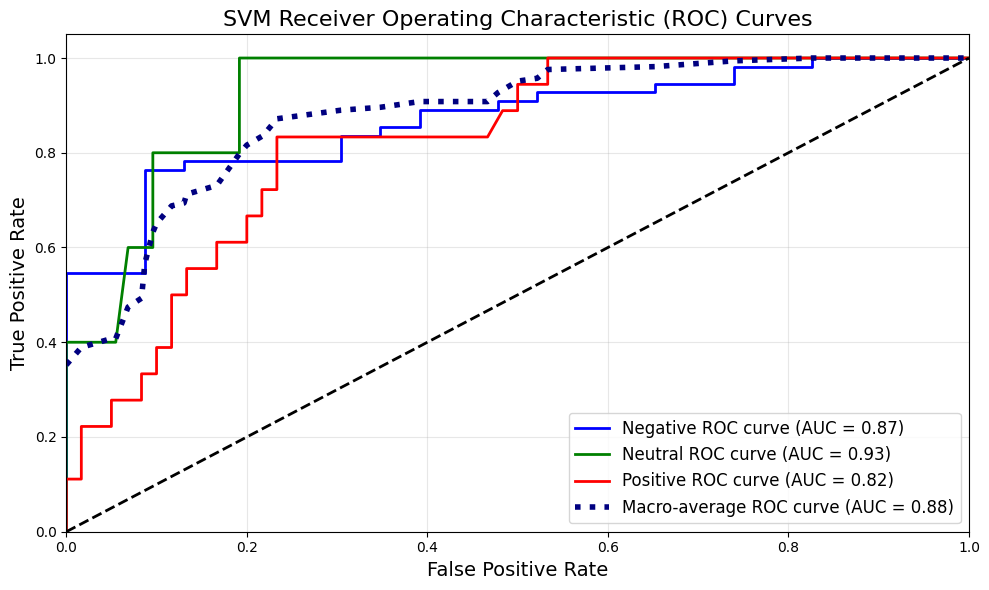

<Figure size 600x400 with 0 Axes>

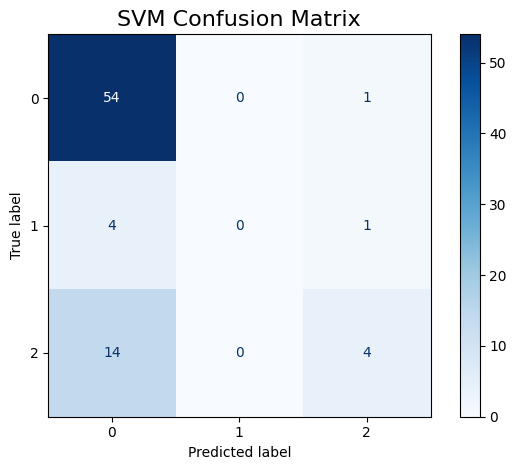

SVM ROC AUC Scores:
Negative (0) ROC AUC: 0.87
Neutral (1) ROC AUC: 0.93
Positive (2) ROC AUC: 0.82
Macro-average ROC AUC: 0.88


In [ ]:
# Import Necessary Libraries
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import numpy as np

# -----------------------------
# 1. Data Preparation
# -----------------------------

# Assuming you have the following variables already defined:
# X_train_vec: Feature vectors for training
# X_test_vec: Feature vectors for testing
# y_train: True labels for training
# y_test: True labels for testing

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on training labels and transform both training and testing labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define Class Labels
class_labels = [0, 1, 2]  # 0: Negative, 1: Neutral, 2: Positive
n_classes = len(class_labels)

# -----------------------------
# 2. Model Training
# -----------------------------

# Create an SVM classifier with the 'rbf' kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)  # Set probability=True for ROC curve

# Train the SVM model
svm_model.fit(X_train_vec, y_train_encoded)

# -----------------------------
# 3. Making Predictions and Evaluations
# -----------------------------

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_vec)

# Evaluate the model
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
precision_svm = precision_score(y_test_encoded, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test_encoded, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test_encoded, y_pred_svm, average='weighted')
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm, labels=class_labels)

# Print Evaluation Metrics
print("SVM Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_svm:.2f}")
print(f"Precision (Weighted): {precision_svm:.2f}")
print(f"Recall (Weighted): {recall_svm:.2f}")
print(f"F1 Score (Weighted): {f1_svm:.2f}")
print("Confusion Matrix:")
print(cm_svm)

# -----------------------------
# 4. ROC Curve Analysis
# -----------------------------

# Binarize the output for ROC computation (One-vs-Rest)
y_test_binarized = label_binarize(y_test_encoded, classes=class_labels)
# Handle the case when there is only one class in y_test
if y_test_binarized.shape[1] != n_classes:
    # Add missing classes as all zeros
    for cls in class_labels:
        if cls not in label_encoder.classes_:
            y_test_binarized = np.hstack((y_test_binarized, np.zeros((y_test_binarized.shape[0], 1))))
    y_test_binarized = y_test_binarized[:, :n_classes]

# Get predicted probabilities
y_score = svm_model.predict_proba(X_test_vec)

# Ensure that y_score columns correspond to class_labels
if not np.array_equal(svm_model.classes_, class_labels):
    # Reorder y_score columns to match class_labels
    sorted_indices = [list(svm_model.classes_).index(cls) for cls in class_labels]
    y_score = y_score[:, sorted_indices]

# Compute ROC curve and ROC area for each class
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

for i, cls in enumerate(class_labels):
    fpr_svm[cls], tpr_svm[cls], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc_svm[cls] = auc(fpr_svm[cls], tpr_svm[cls])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr_svm = np.unique(np.concatenate([fpr_svm[cls] for cls in class_labels]))

# Interpolate all ROC curves at these points
mean_tpr_svm = np.zeros_like(all_fpr_svm)
for cls in class_labels:
    mean_tpr_svm += np.interp(all_fpr_svm, fpr_svm[cls], tpr_svm[cls])

# Average it and compute AUC
mean_tpr_svm /= n_classes

fpr_svm["macro"] = all_fpr_svm
tpr_svm["macro"] = mean_tpr_svm
roc_auc_svm["macro"] = auc(fpr_svm["macro"], tpr_svm["macro"])

# -----------------------------
# 5. Plotting ROC Curves and Confusion Matrix
# -----------------------------

# 5.1. Plot ROC Curves
plt.figure(figsize=(10, 6))

# Define colors for each class
colors = ['blue', 'green', 'red']

for i, cls in enumerate(class_labels):
    sentiment = 'Negative' if cls == 0 else ('Neutral' if cls == 1 else 'Positive')
    plt.plot(
        fpr_svm[cls],
        tpr_svm[cls],
        color=colors[i],
        lw=2,
        label=f'{sentiment} ROC curve (AUC = {roc_auc_svm[cls]:0.2f})'
    )

# Plot macro-average ROC curve
plt.plot(
    fpr_svm["macro"],
    tpr_svm["macro"],
    label=f'Macro-average ROC curve (AUC = {roc_auc_svm["macro"]:0.2f})',
    color='navy',
    linestyle=':',
    linewidth=4
)

# Plot the diagonal line for reference (random chance)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure ROC plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('SVM Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5.2. Plot Confusion Matrix
plt.figure(figsize=(6, 4))

# Create Confusion Matrix Display with descriptive labels
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['0', '1', '2'])
disp_svm.plot(cmap='Blues', values_format='d')
plt.title('SVM Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Print ROC AUC Scores
# -----------------------------

print("SVM ROC AUC Scores:")
print(f"Negative (0) ROC AUC: {roc_auc_svm[0]:.2f}")
print(f"Neutral (1) ROC AUC: {roc_auc_svm[1]:.2f}")
print(f"Positive (2) ROC AUC: {roc_auc_svm[2]:.2f}")
print(f"Macro-average ROC AUC: {roc_auc_svm['macro']:.2f}")


# Random Forest

Random Forest Accuracy: 0.7051282051282052
Random Forest Precision: 0.6718227424749164
Random Forest Recall: 0.7051282051282052
Random Forest F1 Score: 0.6546467731331255


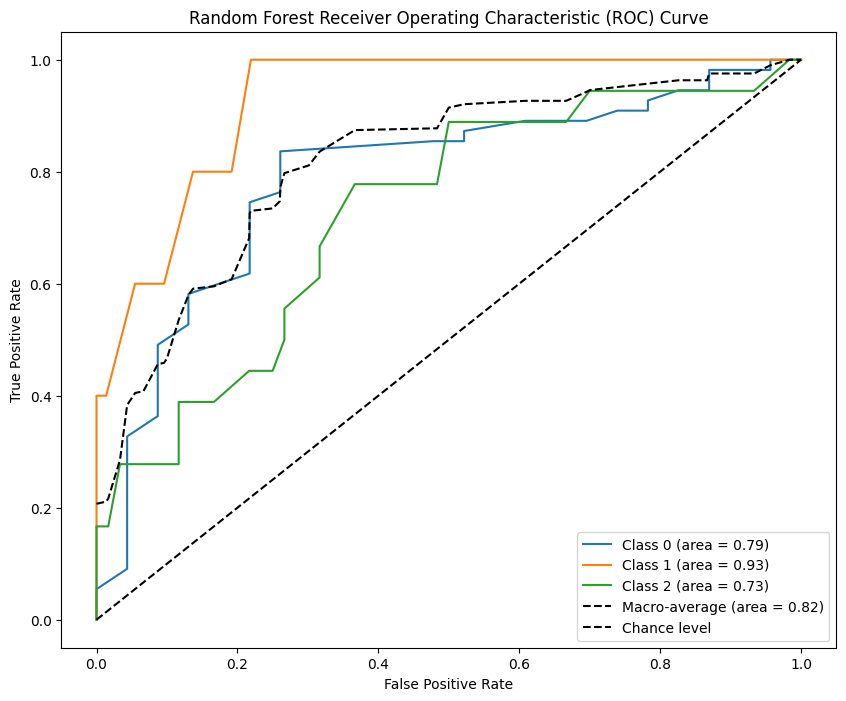

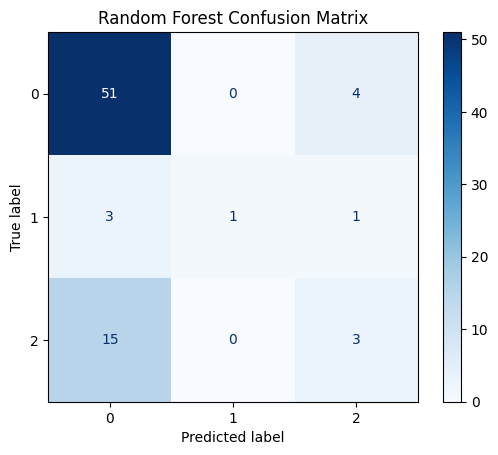

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the data
df = pd.read_excel('/content/Clean Text (1).xlsx')

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Sentiment'], test_size=0.2, random_state=42)

# Preprocessing function for text data
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Apply preprocessing
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_vec, y_train_encoded)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_vec)

# Evaluate the model
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

precision_rf = precision_score(y_test_encoded, y_pred_rf, average='weighted')
print("Random Forest Precision:", precision_rf)

recall_rf = recall_score(y_test_encoded, y_pred_rf, average='weighted')
print("Random Forest Recall:", recall_rf)

f1_rf = f1_score(y_test_encoded, y_pred_rf, average='weighted')
print("Random Forest F1 Score:", f1_rf)

# Binarize the output for ROC computation (One-vs-Rest)
class_labels = np.unique(y_test_encoded)  # Get the class labels
y_test_binarized = label_binarize(y_test_encoded, classes=class_labels)

# Get predicted probabilities
y_pred_proba_rf = rf_classifier.predict_proba(X_test_vec)

# Calculate ROC curve and AUC for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf_class = dict()

for i in range(len(label_encoder.classes_)):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_rf[:, i])
    roc_auc_rf_class[i] = auc(fpr_rf[i], tpr_rf[i])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr_rf = np.unique(np.concatenate([fpr_rf[cls] for cls in class_labels]))

# Interpolate all ROC curves at these points
mean_tpr_rf = np.zeros_like(all_fpr_rf)
for cls in class_labels:
    mean_tpr_rf += np.interp(all_fpr_rf, fpr_rf[cls], tpr_rf[cls])

# Average it and compute AUC
mean_tpr_rf /= len(class_labels)

fpr_rf["macro"] = all_fpr_rf
tpr_rf["macro"] = mean_tpr_rf
roc_auc_rf_class["macro"] = auc(fpr_rf["macro"], tpr_rf["macro"])

# Plot the ROC curves for each class and the macro-average ROC curve
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in class_labels:
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Class {i} (area = {roc_auc_rf_class[i]:0.2f})')

# Plot macro-average ROC curve
plt.plot(fpr_rf["macro"], tpr_rf["macro"], label=f'Macro-average (area = {roc_auc_rf_class["macro"]:0.2f})', color='black', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf)

# Define the class labels
class_labels = ['0', '1', '2']

# Create and plot the confusion matrix with the specified labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)  # You can adjust the colormap as needed
plt.title('Random Forest Confusion Matrix')
plt.show()



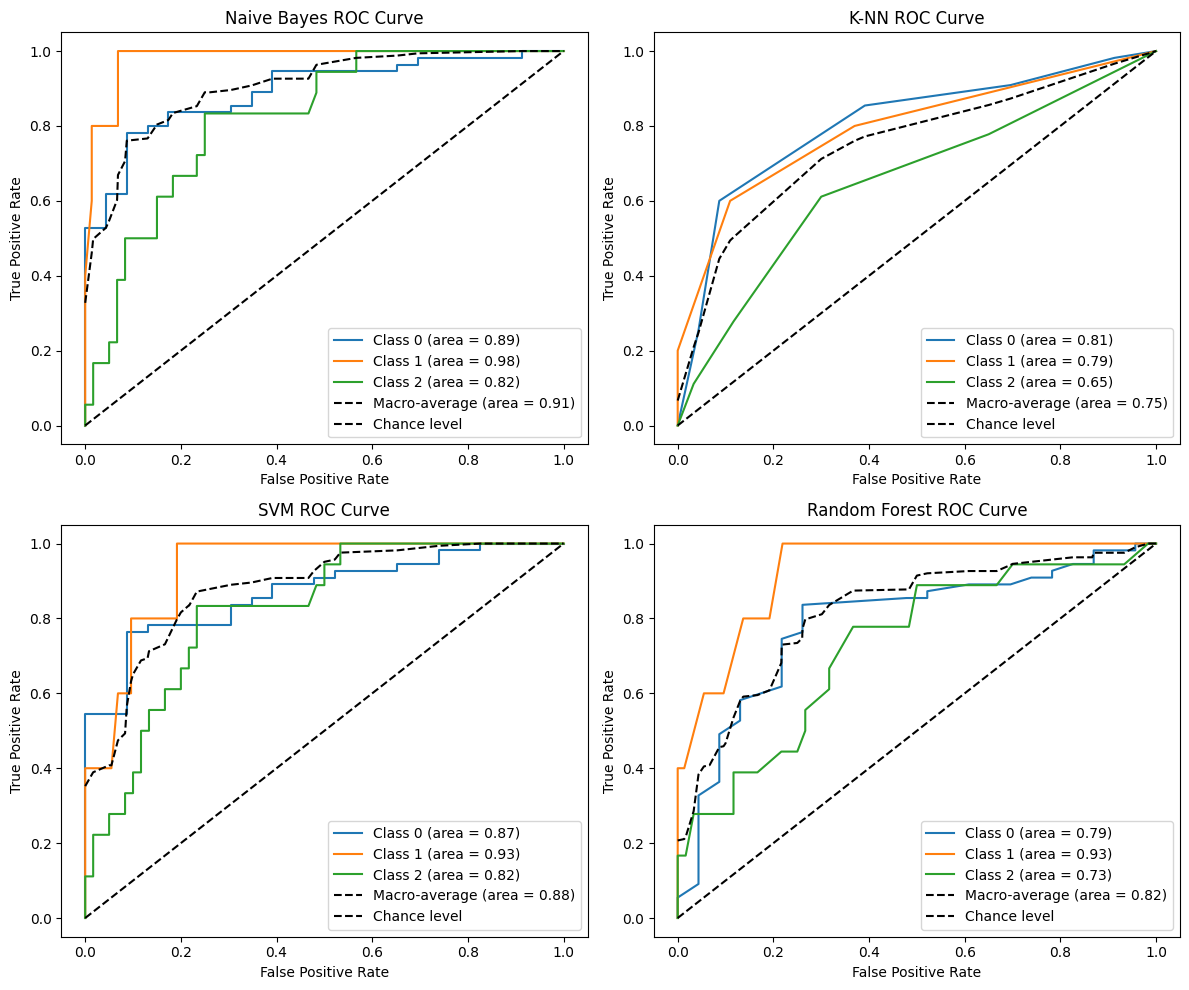

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB  # Import Naive Bayes
# ... (other imports)

# ... (Your existing code for data loading, preprocessing, model training, etc.)

# Assuming you have calculated fpr, tpr, and roc_auc for each model
# (Naive Bayes, KNN, SVM, and Random Forest) and for each class

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Define class labels
class_labels = [0, 1, 2]

# Function to plot ROC curves for a model
def plot_roc_curves(ax, fpr, tpr, roc_auc, model_name):
    for i in class_labels:
        ax.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')
    ax.plot(fpr["macro"], tpr["macro"], label=f'Macro-average (area = {roc_auc["macro"]:0.2f})', color='black', linestyle='--')
    ax.plot([0, 1], [0, 1], 'k--', label='Chance level')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} ROC Curve')
    ax.legend(loc="lower right")


# Plot ROC curves for each model on separate subplots

# Naive Bayes
plot_roc_curves(axs[0, 0], fpr_nb, tpr_nb, roc_auc_nb, 'Naive Bayes')

# KNN
plot_roc_curves(axs[0, 1], fpr_knn, tpr_knn, roc_auc_knn, 'K-NN')

# SVM
plot_roc_curves(axs[1, 0], fpr_svm, tpr_svm, roc_auc_svm, 'SVM')

# Random Forest
plot_roc_curves(axs[1, 1], fpr_rf, tpr_rf, roc_auc_rf_class, 'Random Forest') # Assuming roc_auc_rf_class is defined similarly

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

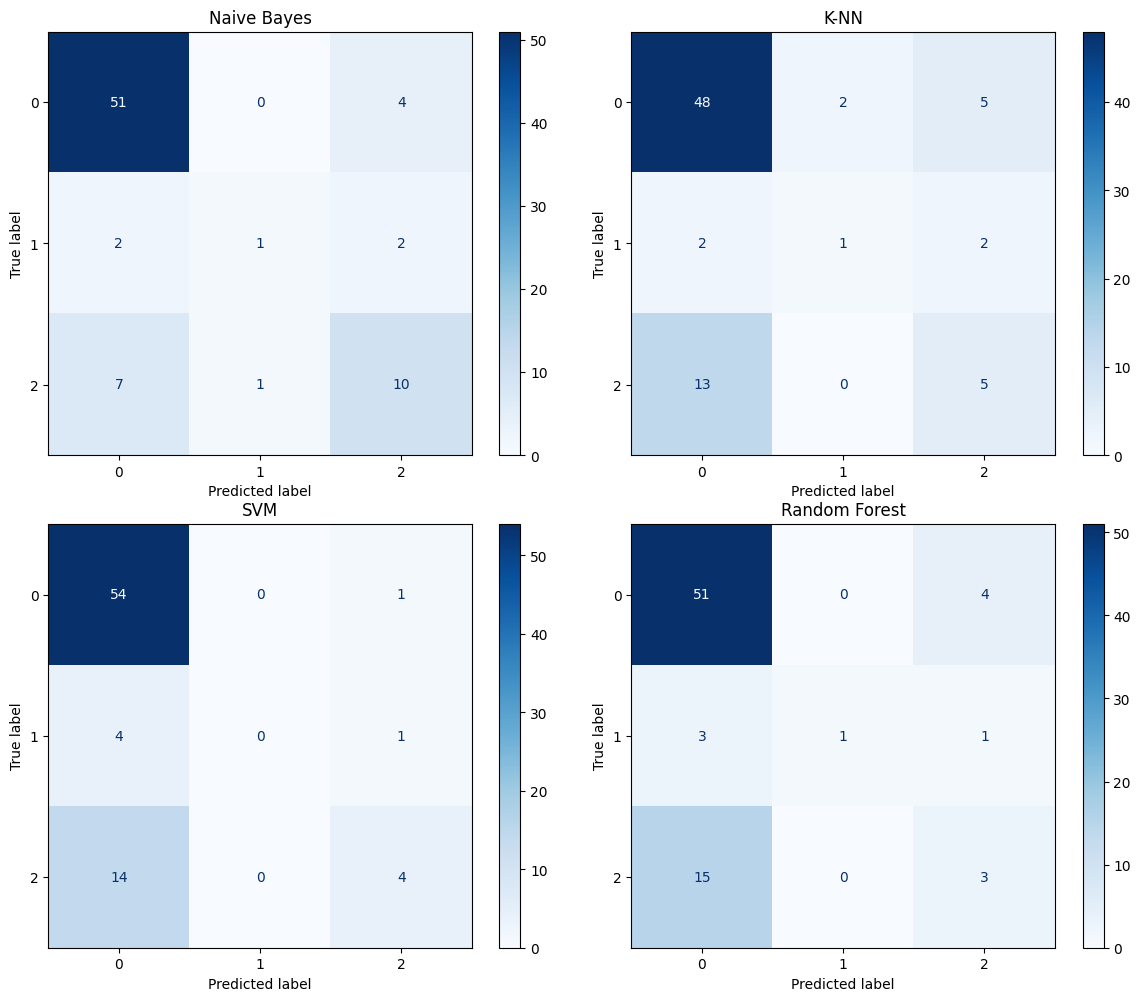

In [ ]:
#  Confusion matrix so that they are in the same subplot of Naive Bayes,KNN,SVM and Random forest

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have already calculated y_pred, y_pred_knn, y_pred_svm, y_pred_rf
# and y_test_encoded for each model

# Define class labels
class_labels = [0, 1, 2]

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Naive Bayes Confusion Matrix
cm_nb = confusion_matrix(y_test_encoded, y_pred, labels=class_labels)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['0', '1', '2'])
disp_nb.plot(ax=axs[0, 0], cmap='Blues', values_format='d')
axs[0, 0].set_title('Naive Bayes')

# KNN Confusion Matrix
cm_knn = confusion_matrix(y_test_encoded, y_pred_knn, labels=class_labels)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['0', '1', '2'])
disp_knn.plot(ax=axs[0, 1], cmap='Blues', values_format='d')
axs[0, 1].set_title('K-NN')

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm, labels=class_labels)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['0', '1', '2'])
disp_svm.plot(ax=axs[1, 0], cmap='Blues', values_format='d')
axs[1, 0].set_title('SVM')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf, labels=class_labels)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['0', '1', '2'])
disp_rf.plot(ax=axs[1, 1], cmap='Blues', values_format='d')
axs[1, 1].set_title('Random Forest')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Comparison of all Traditional Models

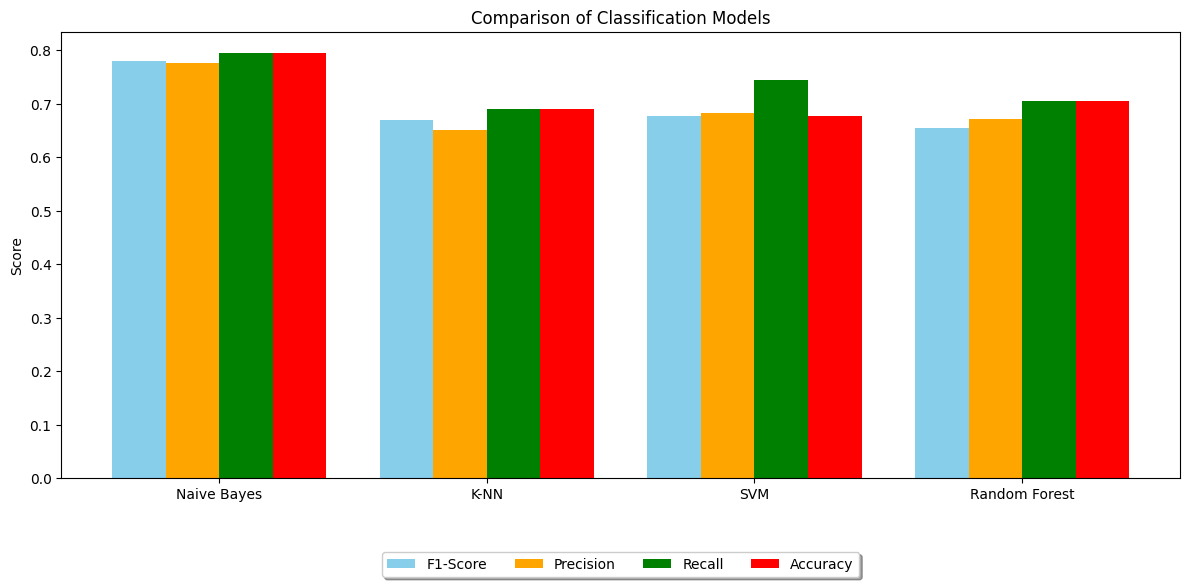

In [ ]:
# Comapre the Naive Bayes, k-nn, svm and Random forest in a bar plot
import matplotlib.pyplot as plt

# Sample data (replace with your actual values)
models = ['Naive Bayes', 'K-NN', 'SVM', 'Random Forest']
f1_scores = [ 0.7794796848505288,0.67 , 0.6765596608116293, 0.6546467731331255]
precisions = [0.7756410256410257, 0.65, 0.6826923076923077, 0.6718227424749164]
recalls = [ 0.7948717948717948, 0.69, 0.7435897435897436 , 0.7051282051282052]
accuracies = [0.7948717948717948, 0.69, 0.6765596608116293, 0.7051282051282052]

x = range(len(models))
width = 0.2

# Plotting the bars
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar([i - 1.5 * width for i in x], f1_scores, width, label='F1-Score', color='skyblue')
rects2 = ax.bar([i - 0.5 * width for i in x], precisions, width, label='Precision', color='orange')
rects3 = ax.bar([i + 0.5 * width for i in x], recalls, width, label='Recall', color='green')
rects4 = ax.bar([i + 1.5 * width for i in x], accuracies, width, label='Accuracy', color='red')

# Adding labels, title, and legend
ax.set_ylabel('Score')
ax.set_title('Comparison of Classification Models')
ax.set_xticks(x)
ax.set_xticklabels(models)

# Legend at the bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4)

# Adding value labels to the bars
def autolabel(rects):
    for rect in rects:ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4)
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


plt.tight_layout()
plt.show()
